#  Real world application : Sunspot frequency prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
from ipywidgets import VBox,IntText,FloatText 

In [2]:
sunspot_df = pd.read_csv("Sunspot_yearly.csv",sep = ';',header = None) # yearly frequency of sunspot activity from 1700 - 2020

In [3]:
sunspot_df.head()

,0,1,2,3,4
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


In [4]:
sunspot_df.shape

(321, 5)

In [5]:
# years is 1st column
# activity is 2nd column
sunspot_array = sunspot_df.values

In [6]:
years = sunspot_array[:,0]
activity = sunspot_array[:,1] + 0.1

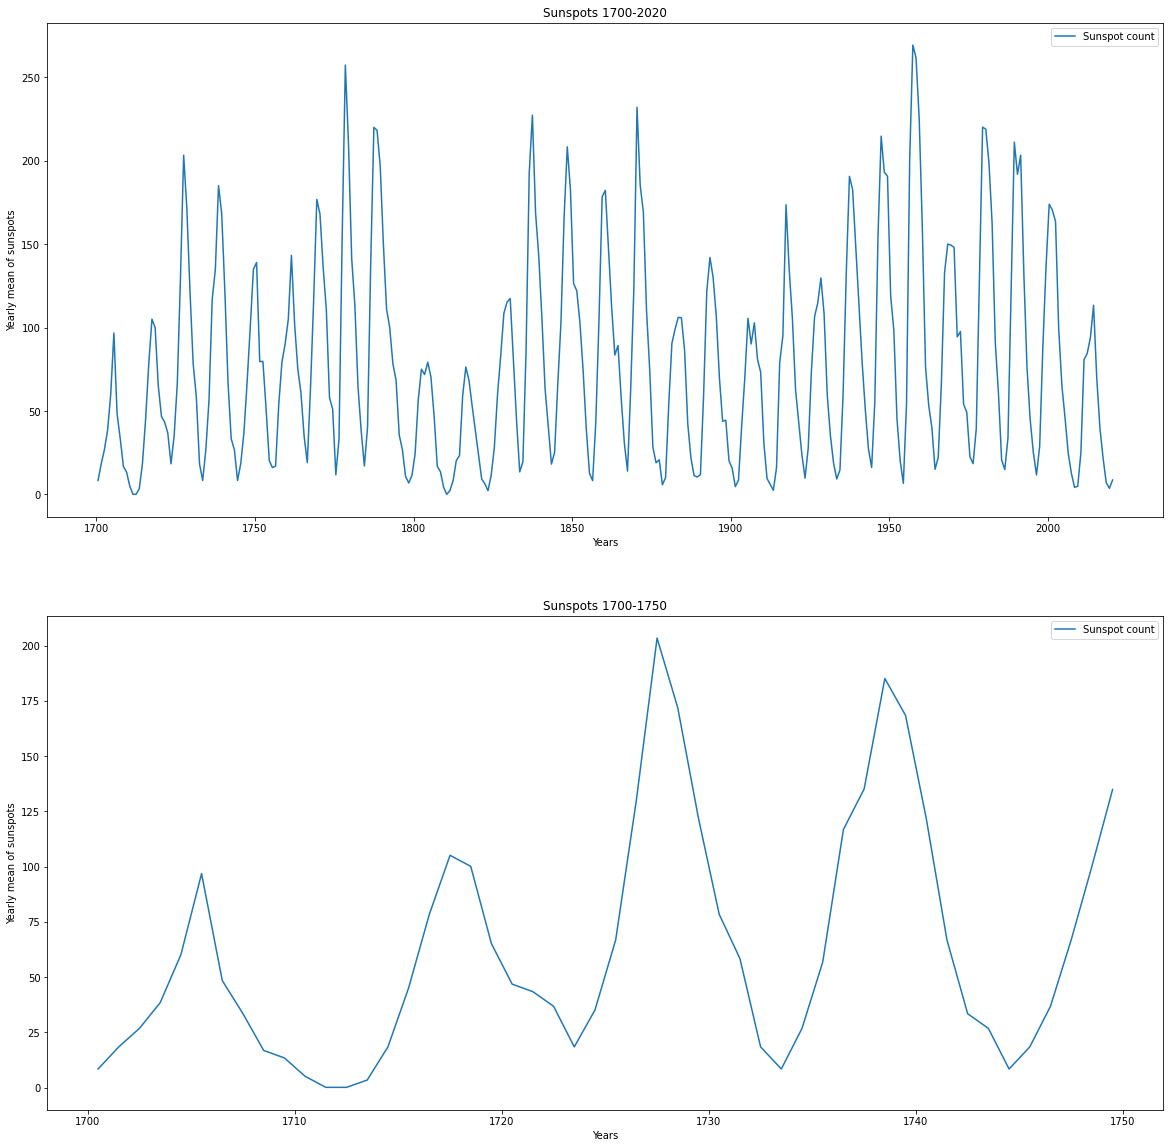

In [7]:
# similar to gamma distribution 
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(2,1,1)
ax.plot(years, activity, label="Sunspot count")
ax.set_title("Sunspots 1700-2020")
ax.set_xlabel("Years")
ax.set_ylabel("Yearly mean of sunspots")
ax.legend()

ax = fig.add_subplot(2,1,2)
ax.plot(years[:50],activity[:50],label = "Sunspot count")
ax.set_title("Sunspots 1700-1750")
ax.set_xlabel("Years")
ax.set_ylabel("Yearly mean of sunspots")
ax.legend()

Text(0.5, 1.0, 'Histogram showing the frequency of sunspot counts over 320 years (1700-2020)')

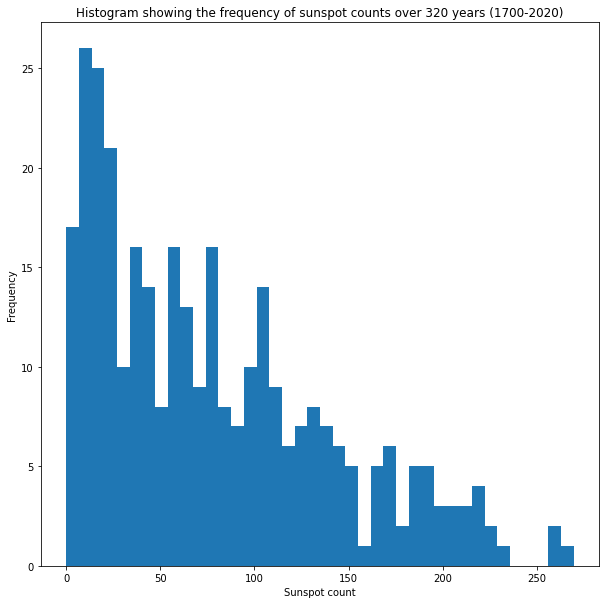

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist(activity, bins=40)
ax.set_xlabel("Sunspot count")
ax.set_ylabel("Frequency")
ax.set_title("Histogram showing the frequency of sunspot counts over 320 years (1700-2020)")

In [9]:
# Above distribution is similar to Gamma Distribution  

## Approximating the shape and scale parameters of the Gamma Distribution

In [10]:
# Prior criteria : k and theta should be positive
def prior(x):
    if(x[0] > 0 or x[1] > 0):
        return 1
    else:
        return 0

In [11]:
# Total Likelihood is product of individual likelihoods 
# We take log for numerical stability

def lik_gamma(x,data):
    return np.sum((x[0]-1)*np.log(data) - x[0]*np.log(x[1]) - data/x[1] - np.log(math.gamma(x[0])))

In [12]:
# Proposal distribution is normal for both 

def proposal(x):
    k = np.random.normal(loc = x[0],scale = 0.05)
    theta = np.random.normal(loc = x[1], scale = 5)
    Prop = [k,theta]
    return Prop

### Metropolis Algorithm

In [13]:
# MH algo acceptance criteria : if target val of y is greater than target value of x then accept 
# else if target value is less than target value of x then check with randomly generated number. If u < target(y)/target(x)
# y = x_new ; everything in log 

def MH_algo(data,k,theta,iterations):
    accepted = []
    x = [k,theta]
    acc = np.array((0,0))
     
    for i in range(iterations):
        x_new =  proposal(x)    
        x_target_new = lik_gamma(x_new,data) + np.log(prior(x_new))
        x_target = lik_gamma(x,data) + np.log(prior(x))
    
     
        if x_target_new > x_target:
            x = x_new
            a = 1
            accepted.append(x_new)
        else:
            u = np.random.rand()
            if u < np.exp(x_target_new - x_target):
                x = x_new
                a = 1 
                accepted.append(x_new)
            else:
                a = 0
        acc = acc + np.array((a, 1))
        
    return np.array(accepted),acc

In [16]:
# Enter values for shape,scale iterations and burn-in
%matplotlib inline

init_k = FloatText(value='1', description = 'Shape(k)')
init_theta = FloatText(value='10', description ='Scale(theta)')
iterations = IntText(value=10000, description ='Iterations')

burnin_input =IntText(value=50, description = 'Burn-in %')

all_widgets = VBox([init_k,
                    init_theta,
                    iterations,
                    burnin_input])
display(all_widgets)


In [19]:
burnin = burnin_input.value  # number of burn-in iterations
k = init_k.value
theta = init_theta.value
samp = iterations.value

accepted,ACC = MH_algo(activity,k,theta,samp)
print(f'Acceptance rate = {ACC[0]*100/ACC[1]} %')
print(f'Last 10 values : \n{accepted[-10:]}')

Acceptance rate = 49.31 %
Last 10 values : 
[[ 1.15914671 64.59142165]
 [ 1.11045902 63.05475312]
 [ 1.14996061 66.1870624 ]
 [ 1.15557731 67.66178613]
 [ 1.19997248 74.85161918]
 [ 1.18713956 72.73043206]
 [ 1.16602124 67.58367435]
 [ 1.17078484 64.57216112]
 [ 1.19913113 68.65747424]
 [ 1.17155635 69.33099929]]


In [20]:
# accepted values after considering burn-in 
burn_in = burnin*0.01
values = int(-burn_in*len(accepted))

Text(0, 0.5, 'Iterations (for theta)')

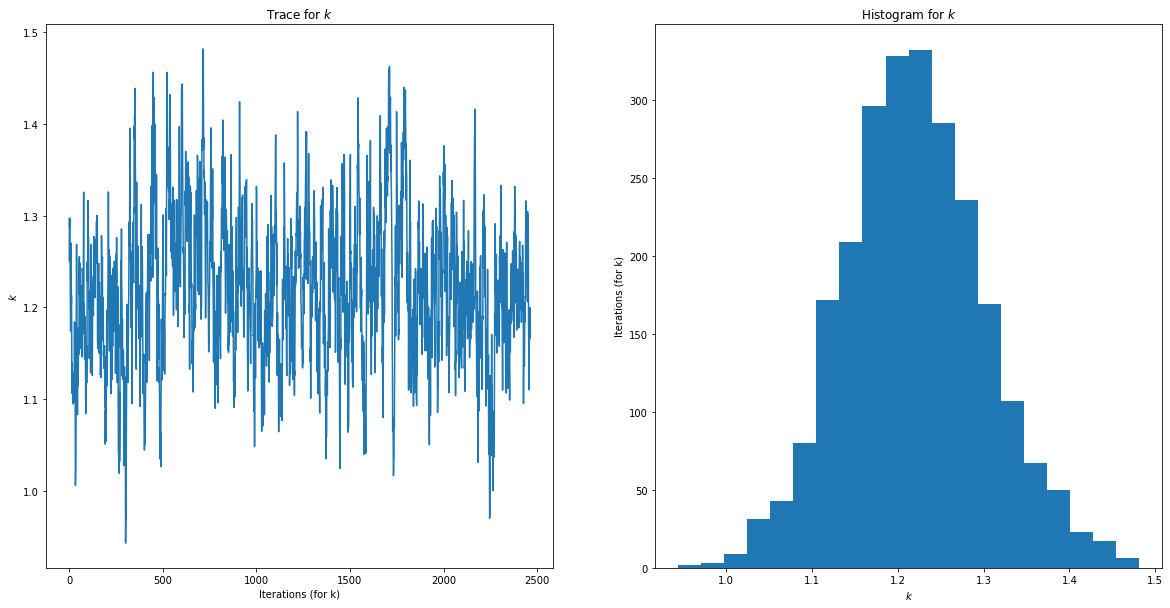

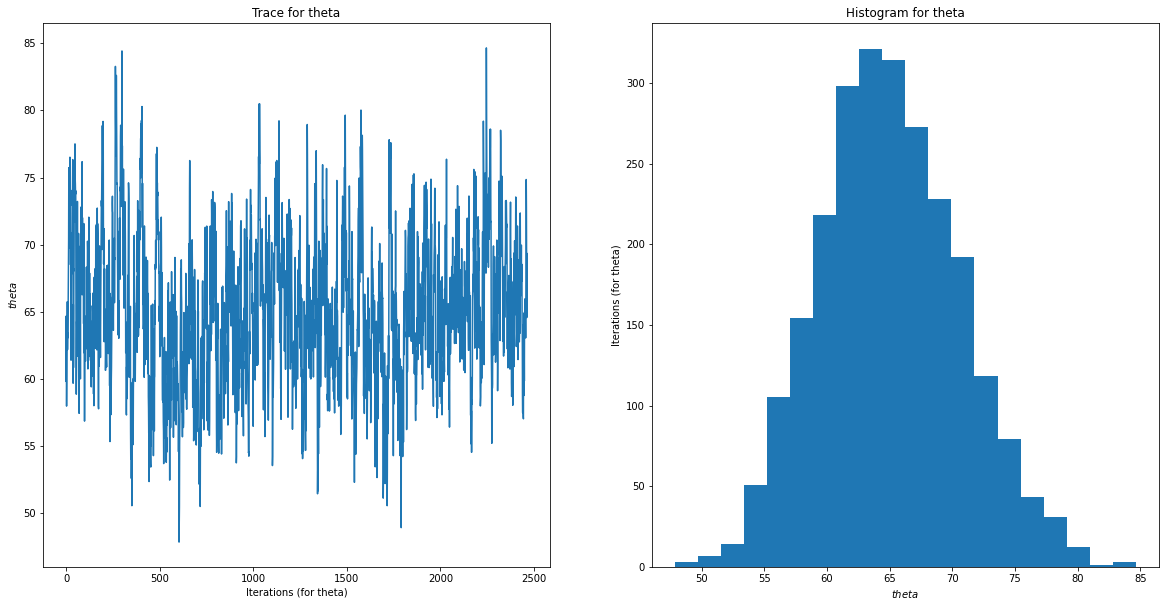

In [21]:
# Plotting predicted values for k and theta 

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[values:,0])
ax.set_title("Trace for $k$")
ax.set_ylabel('$k$')
ax.set_xlabel("Iterations (for k)")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[values:,0],bins = 20)
ax.set_title("Histogram for $k$")
ax.set_xlabel('$k$')
ax.set_ylabel("Iterations (for k)")

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[values:,1])
ax.set_title("Trace for theta")
ax.set_ylabel('$theta$')
ax.set_xlabel("Iterations (for theta)")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[values:,1],bins = 20)
ax.set_title("Histogram for theta")
ax.set_xlabel('$theta$')
ax.set_ylabel("Iterations (for theta)")

# Predicting sunspot frequency 

In [22]:
k_post = accepted[values:,0].mean()
theta_post = accepted[values:,1].mean()


In [23]:
Posterior = np.random.gamma(k_post,scale = theta_post,size = len(activity))

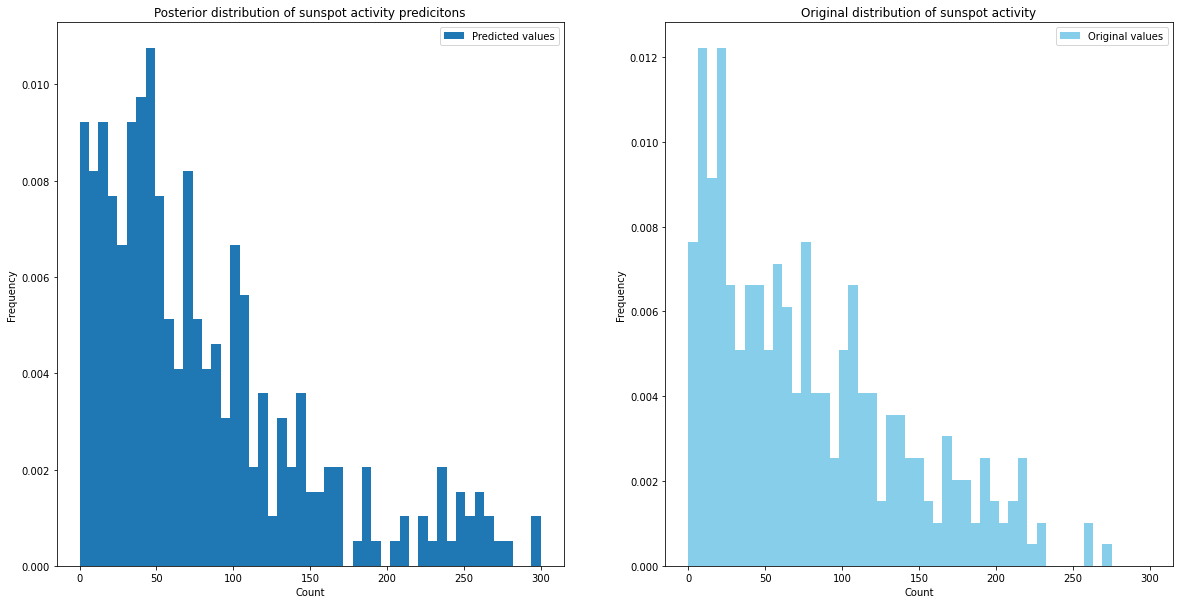

In [24]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.hist(Posterior,bins=np.linspace(0,300,50),label="Predicted values",density = True)
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.legend()
ax.set_title("Posterior distribution of sunspot activity predicitons")
ax = fig.add_subplot(1,2,2)
ax.hist( activity,bins=np.linspace(0,300,50),label = "Original values",color ="skyblue",density = True)
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Original distribution of sunspot activity")
ax.legend()

# Evaluating the model performance 

In [25]:
# lag = 1
k_mean = accepted[values:,0].mean()
t_mean = accepted[values:,1].mean()
print(k_mean,t_mean)

1.2199021765159237 65.01066118321299


In [57]:
# autocorrelation
def autocorr(accepted,lag):
    k_num =0
    k_denom=0
    t_num=0
    t_denom=0
    k_mean = accepted[:,0].mean()
    t_mean = accepted[:,1].mean()
    for i in range(len(accepted) - lag):
        k_num+=(accepted[i,0] - k_mean)*(accepted[i+lag,0]-k_mean)
        t_num+=(accepted[i,1]- t_mean)*(accepted[i+lag,1]-t_mean)
        k_denom+=(accepted[i,0] - k_mean)**2
        t_denom+=(accepted[i,1] - t_mean)**2
    rk = k_num / k_denom
    rt = t_num / t_denom
    return rk, rt

In [58]:
lag_value = 80
lag = np.arange(1,lag_value)

In [64]:
Accepted_val = accepted[values:,:] #after burn-in

In [65]:
result=np.zeros((lag.shape[0],2))
#print(lag)
for l in lag:
    result[l-1,:]=autocorr(Accepted_val,l)

In [66]:
result.shape

(79, 2)

[Text(0, 0.5, 'Autocorrelation'), Text(0.5, 0, 'Lag')]

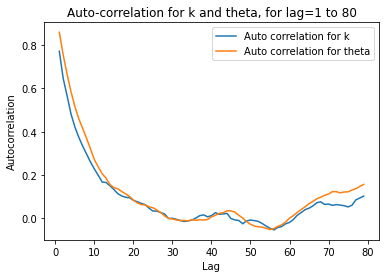

In [67]:
fig, ax = plt.subplots()

ax.plot(lag, result[:,1], label='Auto correlation for k')
ax.plot(lag, result[:,0], label='Auto correlation for theta')
ax.legend(loc=0)
ax.set_title(f"Auto-correlation for k and theta, for lag=1 to {lag_value}")
ax.set(xlabel='Lag', ylabel='Autocorrelation')

In [68]:
thin = np.arange(1,Accepted_val.shape[0],5)
Accept_thin = Accepted_val[thin]

In [69]:
result_thin=np.zeros((lag.shape[0],2))
#print(lag)
for l in lag:
    result_thin[l-1,:]=autocorr(Accept_thin,l)

[Text(0, 0.5, 'Autocorrelation'), Text(0.5, 0, 'Lag')]

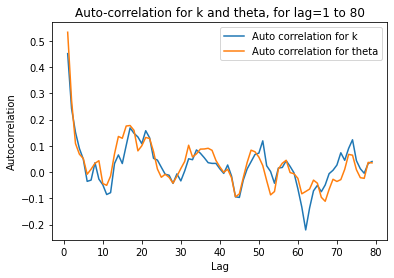

In [70]:
fig, ax = plt.subplots()

ax.plot(lag, result_thin[:,1], label='Auto correlation for k')
ax.plot(lag, result_thin[:,0], label='Auto correlation for theta')
ax.legend(loc=0)
ax.set_title(f"Auto-correlation for k and theta, for lag=1 to {lag_value}")
ax.set(xlabel='Lag', ylabel='Autocorrelation')

In [71]:
np.var(Accepted_val)

1032.7608957095042

In [72]:
np.var(Accept_thin)

1036.67090831041